## Importing Libraries

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(style="ticks")
from datetime import date


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")

pd.set_option('display.max_columns', 100)
np.random.seed(42)

%matplotlib inline

## Import datasets

In [3]:
# Customer data
customers = 'https://drive.google.com/file/d/1meyq2bcJREBUIBpFVcBs8cN07FJggann/view?usp=sharing'
customers = 'https://drive.google.com/uc?id=' + customers.split('/')[-2]
customers = pd.read_csv(customers)
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
# Orders data
orders = 'https://drive.google.com/file/d/1MksdL1yVTGFg2ehi07g83SY2MtltLGn2/view?usp=sharing'
orders = 'https://drive.google.com/uc?id=' + orders.split('/')[-2]
orders = pd.read_csv(orders)
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
# Payments data
payments = 'https://drive.google.com/file/d/1GKBn7G2Pk49yV6lCdUFQ0lLp6YB7kvYn/view?usp=sharing'
payments = 'https://drive.google.com/uc?id=' + payments.split('/')[-2]
payments = pd.read_csv(payments)
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [6]:
# Items data
items = 'https://drive.google.com/file/d/1ToztsKqkRoy5g6JPKJ7bQELPCtkmIpf0/view?usp=sharing'
items = 'https://drive.google.com/uc?id=' + items.split('/')[-2]
items = pd.read_csv(items)
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
# Product data
products = 'https://drive.google.com/file/d/13kPIR70wtL53A62Z56BjMdxaWhPeU6mj/view?usp=sharing'
products = 'https://drive.google.com/uc?id=' + products.split('/')[-2]
products = pd.read_csv(products)
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [8]:
# Sellers data
sellers = 'https://drive.google.com/file/d/1yDMn_QzQ-Kk5J1IDhoADqDB06p8BRAJU/view?usp=sharing'
sellers = 'https://drive.google.com/uc?id=' + sellers.split('/')[-2]
sellers = pd.read_csv(sellers)
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [9]:
# Review data
reviews = 'https://drive.google.com/file/d/1ZtAha5Xa7g4nEiIVMivyh0kpfWGNhOvF/view?usp=sharing'
reviews = 'https://drive.google.com/uc?id=' + reviews.split('/')[-2]
reviews = pd.read_csv(reviews)
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [10]:
# Geolocation data
geo = 'https://drive.google.com/file/d/1Wif3-LKrqSK5_GrCm5zgKrXd522sl99C/view?usp=sharing'
geo = 'https://drive.google.com/uc?id=' + geo.split('/')[-2]
geo = pd.read_csv(geo)
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [11]:
# Merged data
merged = 'https://drive.google.com/file/d/13pOEdvCZeN3hec_nXCiuNjRhRAteLI9z/view?usp=sharing'
merged = 'https://drive.google.com/uc?id=' + merged.split('/')[-2]
merged = pd.read_csv(merged)
merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,zip_code_c,customer_city,customer_state,geo_city_c,geo_state_c,order_item_id,product_id,seller_id,price,freight_value,zip_code_s,seller_city,seller_state,geo_city_s,geo_state_s,product_category_name,review_id,review_score,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,9350,maua,SP,maua,SP,utilidades_domesticas,a54f0611adc9ed256b57ede6b6eb5114,4,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,9350,maua,SP,maua,SP,utilidades_domesticas,a54f0611adc9ed256b57ede6b6eb5114,4,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,9350,maua,SP,maua,SP,utilidades_domesticas,a54f0611adc9ed256b57ede6b6eb5114,4,2,voucher,1,18.59
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,88032,florianopolis,SC,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,14.10,9350,maua,SP,maua,SP,utilidades_domesticas,1bafb430e498b939f258b9c9dbdff9b1,3,1,boleto,1,44.09
4,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,3366,sao paulo,SP,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,9350,maua,SP,maua,SP,utilidades_domesticas,b46f1e34512b0f4c74a72398b03ca788,4,1,credit_card,3,37.77


### Description of the dataset
* **order_status** : Reference to the order status (delivered, shipped, etc).
* **order_item_id** : sequential number identifying number of items included in the same order.
* **freight_value** : item freight value item (if an order has more than one item the freight value is splitted between items)
* **payment_sequential** : a customer may pay an order with more than one payment method. If so, a sequence will be created to accommodate all payments.
* **payment_installment** : number of installments chosen by the customer.
* **payment_value** : transaction value.

## Know Our Data Metrics

In [12]:
# creating master dataframe

df1 = payments.merge(items, on='order_id')
df2 = df1.merge(orders, on='order_id')
data = df2.merge(customers, on='customer_id')
print(data.shape)
data.head()

(117601, 22)


,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16 00:00:00,a8b9d3a27068454b1c98cc67d4e31e6f,2422,sao paulo,SP
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04 00:00:00,6f70c0b2f7552832ba46eb57b1c5651e,2652,sao paulo,SP
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1,548e5bfe28edceab6b51fa707cc9556f,da8622b14eb17ae2831f4ac5b9dab84a,2017-12-12 12:13:20,89.90,17.88,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00,87695ed086ebd36f20404c82d20fca87,36060,juiz de fora,MG
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1,386486367c1f9d4f587a8864ccb6902b,cca3071e3e9bb7d12640c9fbe2301306,2018-05-31 16:14:41,113.57,14.88,15fd6fb8f8312dbb4674e4518d6fa3b3,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00,4291db0da71914754618cd789aebcd56,18570,conchas,SP


In [13]:
# creating a new dataframe with only the customer details necessary for calculating metrics

df = data.loc[:,['order_id','customer_unique_id','customer_id','order_purchase_timestamp','order_status','payment_value']]
df.columns = ['OrderID','CustomerUniqueID','CustomerID','PurchaseTime','OrderStatus','PaymentValue']
df.head()

,OrderID,CustomerUniqueID,CustomerID,PurchaseTime,OrderStatus,PaymentValue
0,b81ef226f3fe1789b1e8b2acac839d17,708ab75d2a007f0564aedd11139c7708,0a8556ac6be836b46b3e89920d59291c,2018-04-25 22:01:49,delivered,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,a8b9d3a27068454b1c98cc67d4e31e6f,f2c7fc58a9de810828715166c672f10a,2018-06-26 11:01:38,delivered,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,6f70c0b2f7552832ba46eb57b1c5651e,25b14b69de0b6e184ae6fe2755e478f9,2017-12-12 11:19:55,delivered,65.71
3,ba78997921bbcdc1373bb41e913ab953,87695ed086ebd36f20404c82d20fca87,7a5d8efaaa1081f800628c30d2b0728f,2017-12-06 12:04:06,delivered,107.78
4,42fdf880ba16b47b59251dd489d4441a,4291db0da71914754618cd789aebcd56,15fd6fb8f8312dbb4674e4518d6fa3b3,2018-05-21 13:59:17,delivered,128.45


**Description of the dataset** <br>
**OrderID :** ID of the order placed <br>
**CustomerUniqueID :**  Unique ID of a customer <br>
**CustomerID :** Customer ID <br>
**PurchaseTime :** Datetime of order delivered <br>
**OrderStatus :** Reference to the status of order (delivered, shipped, etc) <br>
**PaymentValue :** Amount paid by the customer for the order <br>

## EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   OrderID           117601 non-null  object 
 1   CustomerUniqueID  117601 non-null  object 
 2   CustomerID        117601 non-null  object 
 3   PurchaseTime      117601 non-null  object 
 4   OrderStatus       117601 non-null  object 
 5   PaymentValue      117601 non-null  float64
dtypes: float64(1), object(5)
memory usage: 6.3+ MB


In [15]:
#converting the PurchaseTime Dtype to datetime
df['PurchaseTime'] = pd.to_datetime(df['PurchaseTime'] , format='%Y-%m-%d %H:%M:%S')

In [16]:
df.describe()

,PaymentValue
count,117601.000000
mean,172.686752
std,267.592290
min,0.000000
25%,60.870000
50%,108.210000
75%,189.260000
max,13664.080000


In [17]:
# displaying missing value counts and corresponding percentage against total observations
missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Values', 'Percentage']).transpose()

#No nan values

,OrderID,CustomerUniqueID,CustomerID,PurchaseTime,OrderStatus,PaymentValue
Values,0.0,0.0,0.0,0.0,0.0,0.0
Percentage,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# dropping the duplicate entries (which might have been created due to the merged payment details)
print('Shape before duplicates: ',df.shape)
df.drop_duplicates(inplace=True)
print('Shape after duplicates: ',df.shape)

Shape before duplicates:  (117601, 6)
Shape after duplicates:  (102460, 6)


In [19]:
# displaying dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102460 entries, 0 to 117600
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   OrderID           102460 non-null  object        
 1   CustomerUniqueID  102460 non-null  object        
 2   CustomerID        102460 non-null  object        
 3   PurchaseTime      102460 non-null  datetime64[ns]
 4   OrderStatus       102460 non-null  object        
 5   PaymentValue      102460 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 5.5+ MB


The dataframe **df** constitutes of columns from the 4 independent dataset provided, joined together via unique keys. Only the columns needed for the following metric calculations are retained.

### Monthly Revenue

In [20]:
month = df.PurchaseTime.apply(lambda x: x.month).astype(str)
month = month.apply(lambda x: '0' + x if len(x) == 1 else x)

year =  df.PurchaseTime.apply(lambda x: x.year)

df['YearMonth'] = year.astype(str) + '-' + month.astype(str)

In [21]:
# excluding incomplete 2016 and 2018 data 
df = df.query("YearMonth != '2016-12' and YearMonth != '2016-10' and YearMonth != '2016-09' and YearMonth != '2018-09'")
df.head()

,OrderID,CustomerUniqueID,CustomerID,PurchaseTime,OrderStatus,PaymentValue,YearMonth
0,b81ef226f3fe1789b1e8b2acac839d17,708ab75d2a007f0564aedd11139c7708,0a8556ac6be836b46b3e89920d59291c,2018-04-25 22:01:49,delivered,99.33,2018-04
1,a9810da82917af2d9aefd1278f1dcfa0,a8b9d3a27068454b1c98cc67d4e31e6f,f2c7fc58a9de810828715166c672f10a,2018-06-26 11:01:38,delivered,24.39,2018-06
2,25e8ea4e93396b6fa0d3dd708e76c1bd,6f70c0b2f7552832ba46eb57b1c5651e,25b14b69de0b6e184ae6fe2755e478f9,2017-12-12 11:19:55,delivered,65.71,2017-12
3,ba78997921bbcdc1373bb41e913ab953,87695ed086ebd36f20404c82d20fca87,7a5d8efaaa1081f800628c30d2b0728f,2017-12-06 12:04:06,delivered,107.78,2017-12
4,42fdf880ba16b47b59251dd489d4441a,4291db0da71914754618cd789aebcd56,15fd6fb8f8312dbb4674e4518d6fa3b3,2018-05-21 13:59:17,delivered,128.45,2018-05


In [22]:
#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
df_revenue = df.groupby(['YearMonth'])['PaymentValue'].sum().reset_index()
df_revenue.columns = ['YearMonth','Revenue']
df_revenue

,YearMonth,Revenue
0,2017-01,136826.77
1,2017-02,285776.94
2,2017-03,431903.90
3,2017-04,412202.99
4,2017-05,585163.69
5,2017-06,502675.07
6,2017-07,583676.60
7,2017-08,667851.36
8,2017-09,718428.68
9,2017-10,768528.43


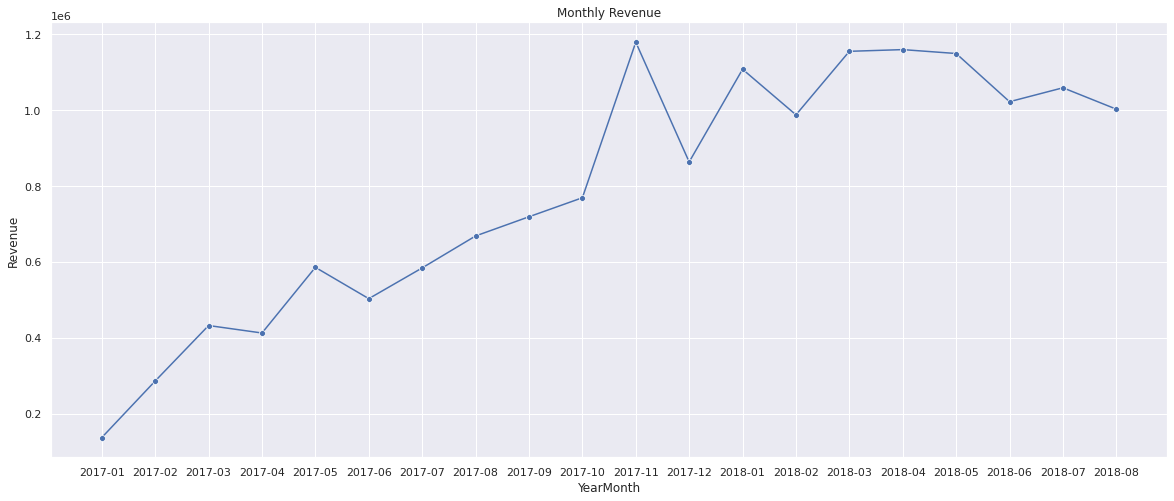

In [23]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot(data=df_revenue, x="YearMonth", y="Revenue", marker='o')
plt.title('Monthly Revenue')
plt.show()

### Monthly Revenue Growth Rate

In [24]:
df_revenue['MonthlyGrowth'] = df_revenue['Revenue'].pct_change()
df_revenue.head()

,YearMonth,Revenue,MonthlyGrowth
0,2017-01,136826.77,NaN
1,2017-02,285776.94,1.088604
2,2017-03,431903.90,0.511332
3,2017-04,412202.99,-0.045614
4,2017-05,585163.69,0.419601


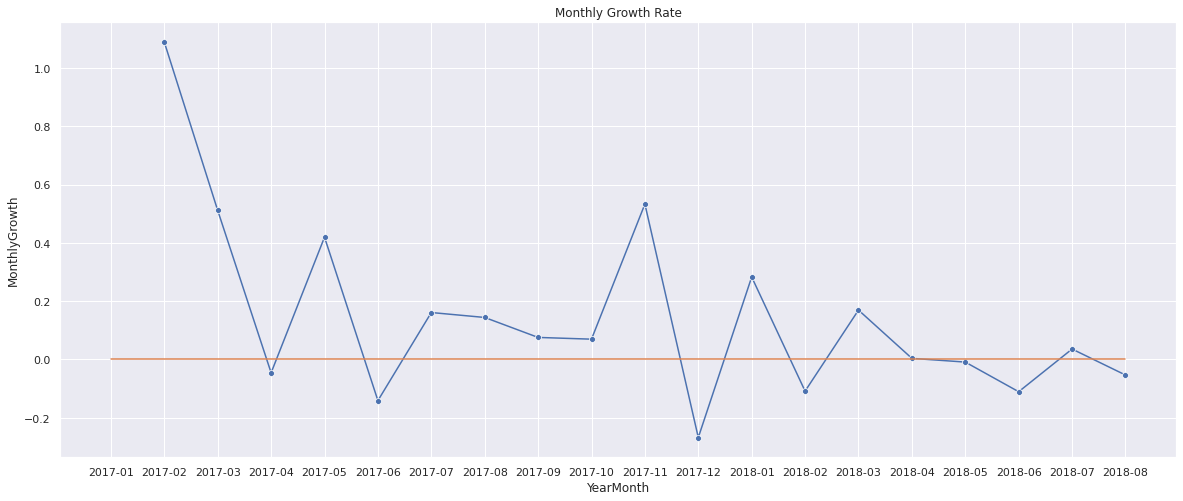

In [25]:
sns.lineplot(data=df_revenue, x="YearMonth", y="MonthlyGrowth", marker='o')
sns.lineplot(data=df_revenue, x="YearMonth", y=np.zeros(df_revenue.shape[0]))
plt.title('Monthly Growth Rate')
plt.show()

### Monthly Active Customers

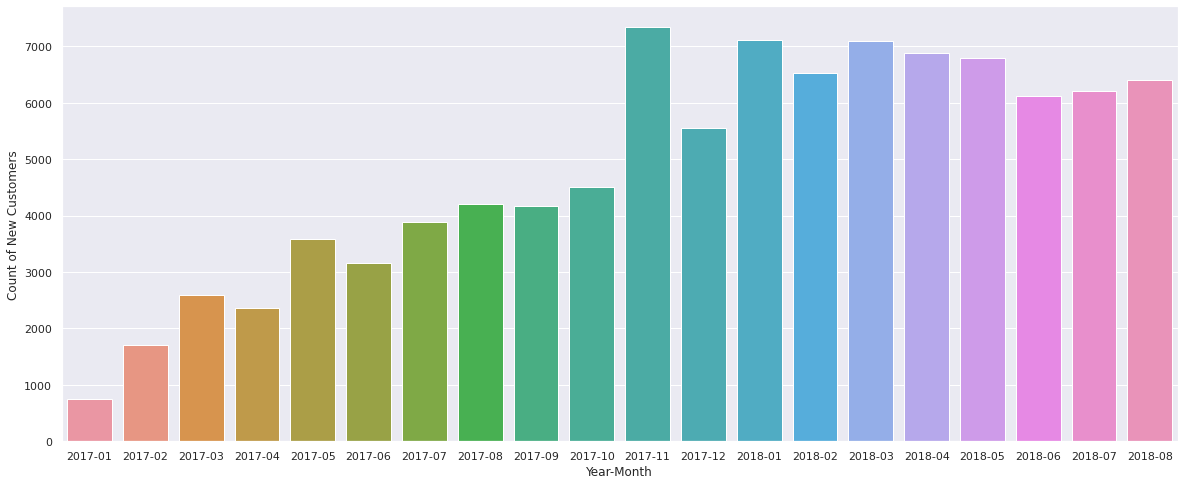

In [26]:
#creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_active = df.groupby('YearMonth')['CustomerUniqueID'].nunique().reset_index()
df_monthly_active.columns = ['YearMonth','UniqueCustomer']


sns.barplot(x='YearMonth', y='UniqueCustomer', data=df_monthly_active)
plt.ylabel('Count of New Customers')
plt.xlabel('Year-Month')
plt.show()

### Monthly Order Count

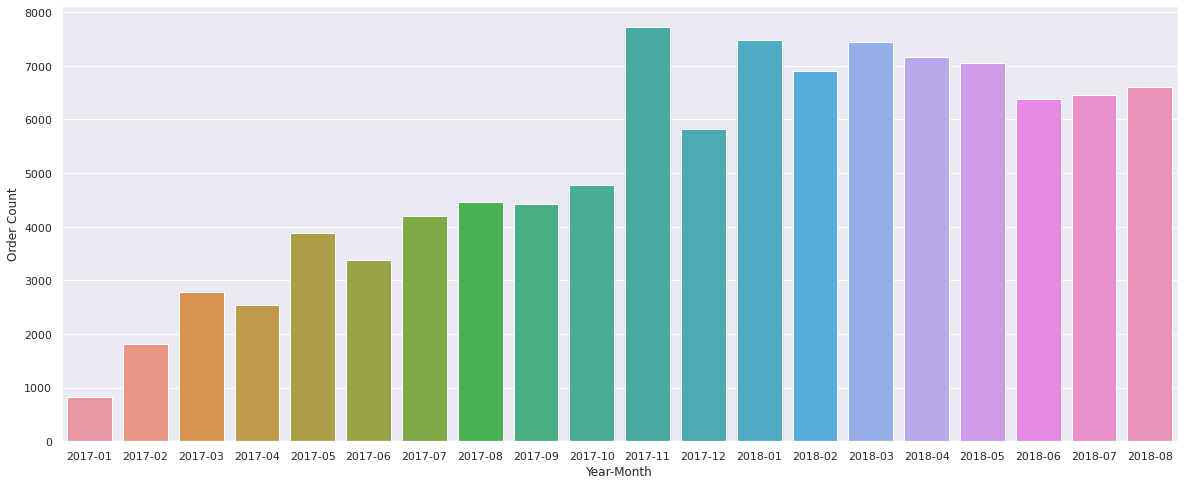

In [27]:
#creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_sales = df.groupby('YearMonth')['OrderStatus'].count().reset_index()
df_monthly_sales.columns = ['YearMonth','OrderCount']

sns.barplot(x='YearMonth', y='OrderCount', data=df_monthly_sales)
plt.ylabel('Order Count')
plt.xlabel('Year-Month')
plt.show()

### Average Revenue per Order

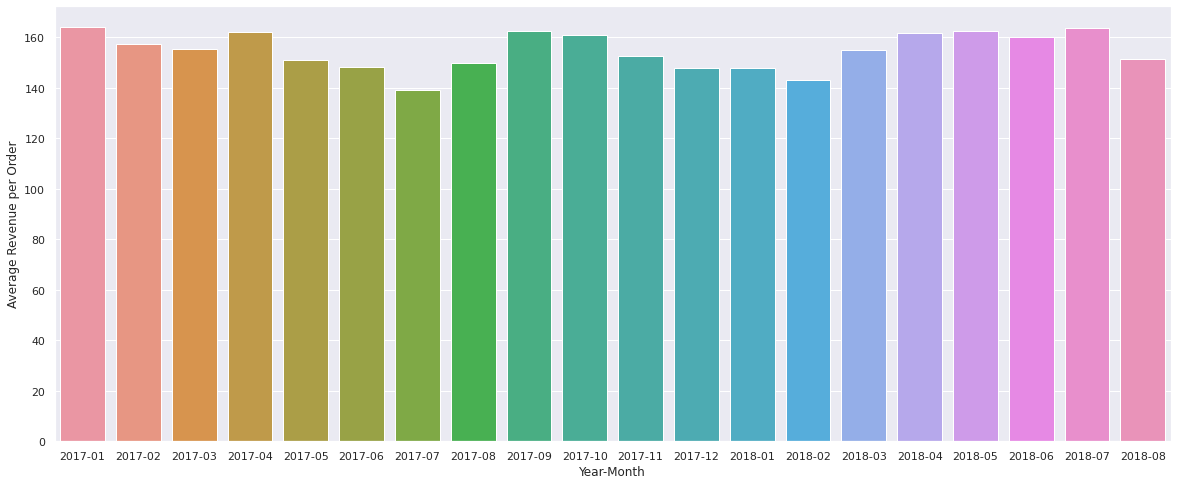

In [28]:
# create a new dataframe for average revenue by taking the mean of it
df_monthly_order_avg = df.groupby('YearMonth')['PaymentValue'].mean().reset_index()
df_monthly_order_avg.columns = ['YearMonth','AvgRevenuePerOrder']

sns.barplot(x='YearMonth', y='AvgRevenuePerOrder', data=df_monthly_order_avg)
plt.ylabel('Average Revenue per Order')
plt.xlabel('Year-Month')
plt.show()

### New Customer Ratio

In [29]:
#create a dataframe contaning CustomerID and first purchase date
df_min_purchase = df.groupby('CustomerUniqueID').PurchaseTime.min().reset_index()
df_min_purchase.columns = ['CustomerUniqueID','MinPurchaseDate']
df_min_purchase['MinPurchaseDate'] = df_min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)

df_min_purchase.head()

,CustomerUniqueID,MinPurchaseDate
0,0000366f3b9a7992bf8c76cfdf3221e2,201805
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805
2,0000f46a3911fa3c0805444483337064,201703
3,0000f6ccb0745a6a4b88665a16c9f078,201710
4,0004aac84e0df4da2b147fca70cf8255,201711


In [30]:
#merge first purchase date column to our main dataframe df
df = pd.merge(df, df_min_purchase, on='CustomerUniqueID')
df.head()

,OrderID,CustomerUniqueID,CustomerID,PurchaseTime,OrderStatus,PaymentValue,YearMonth,MinPurchaseDate
0,b81ef226f3fe1789b1e8b2acac839d17,708ab75d2a007f0564aedd11139c7708,0a8556ac6be836b46b3e89920d59291c,2018-04-25 22:01:49,delivered,99.33,2018-04,201804
1,a9810da82917af2d9aefd1278f1dcfa0,a8b9d3a27068454b1c98cc67d4e31e6f,f2c7fc58a9de810828715166c672f10a,2018-06-26 11:01:38,delivered,24.39,2018-06,201806
2,25e8ea4e93396b6fa0d3dd708e76c1bd,6f70c0b2f7552832ba46eb57b1c5651e,25b14b69de0b6e184ae6fe2755e478f9,2017-12-12 11:19:55,delivered,65.71,2017-12,201712
3,ba78997921bbcdc1373bb41e913ab953,87695ed086ebd36f20404c82d20fca87,7a5d8efaaa1081f800628c30d2b0728f,2017-12-06 12:04:06,delivered,107.78,2017-12,201712
4,42fdf880ba16b47b59251dd489d4441a,4291db0da71914754618cd789aebcd56,15fd6fb8f8312dbb4674e4518d6fa3b3,2018-05-21 13:59:17,delivered,128.45,2018-05,201805


In [31]:
#create a column called User Type and assign Existing if User's First Purchase Year Month before the selected Year Month
df['UserType'] = 'New'

#creating a new col of YearMonth with type int for comparison 
df['YearMonthInt'] = df['PurchaseTime'].map(lambda date: 100*date.year + date.month)

df.loc[df['YearMonthInt']>df['MinPurchaseDate'],'UserType'] = 'Existing'

#calculate the Revenue per month for each user type
df_user_type_revenue = df.groupby(['YearMonth','UserType'])['PaymentValue'].sum().reset_index()

df_user_type_revenue

,YearMonth,UserType,PaymentValue
0,2017-01,New,136826.77
1,2017-02,Existing,170.83
2,2017-02,New,285606.11
3,2017-03,Existing,650.82
4,2017-03,New,431253.08
5,2017-04,Existing,2455.30
6,2017-04,New,409747.69
7,2017-05,Existing,5039.10
8,2017-05,New,580124.59
9,2017-06,Existing,5981.11


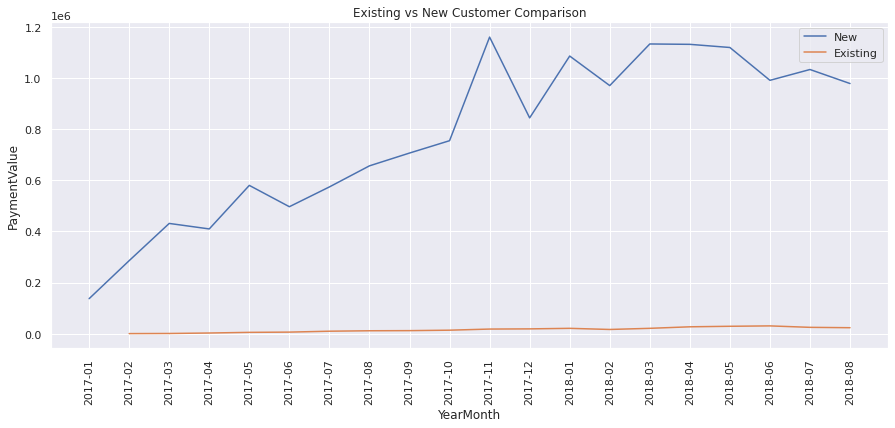

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.set(palette='muted', color_codes=True)
ax = sns.lineplot(x='YearMonth', y='PaymentValue', data=df_user_type_revenue.query("UserType == 'New'"), label='New')
ax = sns.lineplot(x='YearMonth', y='PaymentValue', data=df_user_type_revenue.query("UserType == 'Existing'"), label='Existing')
ax.set_title('Existing vs New Customer Comparison')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [33]:
#create a dataframe that shows new user ratio - we also need to drop NA values (as first month new user  is 0)
df_user_ratio = df.query("UserType == 'New'").groupby(['YearMonth'])['CustomerUniqueID'].nunique()/df.query("UserType == 'Existing'").groupby(['YearMonth'])['CustomerUniqueID'].nunique() 
df_user_ratio = df_user_ratio.reset_index()

#dropping nan values that resulted from first and last month
df_user_ratio = df_user_ratio.dropna()
df_user_ratio.columns = ['YearMonth','NewCustomerRatio']

#print the dafaframe
df_user_ratio

,YearMonth,NewCustomerRatio
1,2017-02,568.333333
2,2017-03,432.500000
3,2017-04,123.157895
4,2017-05,127.142857
5,2017-06,77.850000
6,2017-07,76.880000
7,2017-08,66.919355
8,2017-09,51.784810
9,2017-10,49.573034
10,2017-11,58.209677


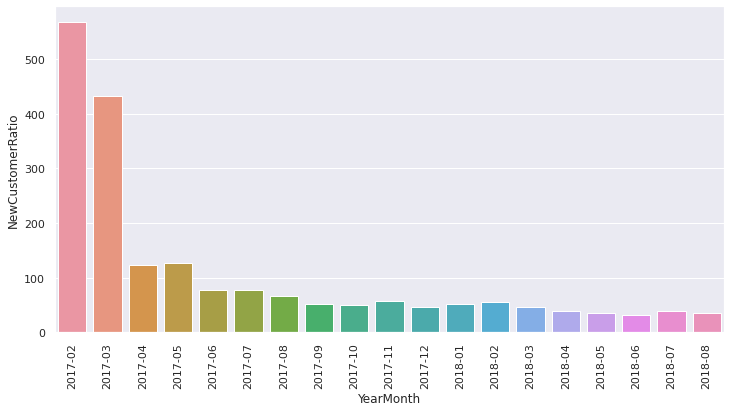

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
sns.barplot(x='YearMonth', y='NewCustomerRatio', data=df_user_ratio)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# Monthly Retention Rate

In [35]:
#Monthly Retention Rate = Retained Customers From Prev. Month/Active Customers Total (using crosstab)

#identifying active users by looking at their revenue per month
df_user_purchase = df.groupby(['CustomerUniqueID','YearMonthInt'])['PaymentValue'].sum().reset_index()
df_user_purchase.head()

,CustomerUniqueID,YearMonthInt,PaymentValue
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,27.19
2,0000f46a3911fa3c0805444483337064,201703,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,201710,43.62
4,0004aac84e0df4da2b147fca70cf8255,201711,196.89


In [36]:
#creating retention matrix with crosstab using df_user_purchase
df_retention = pd.crosstab(df_user_purchase['CustomerUniqueID'], df_user_purchase['YearMonthInt']).reset_index()
df_retention.head()

YearMonthInt,CustomerUniqueID,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0000f46a3911fa3c0805444483337064,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [37]:
#creating an array of dictionary which keeps Retained & Total User count for each month
months = df_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['YearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = df_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = df_retention[(df_retention[selected_month]>0) & (df_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
df_retention = pd.DataFrame(retention_array)
df_retention['RetentionRate'] = df_retention['RetainedUserCount']/df_retention['TotalUserCount']

df_retention

,YearMonth,TotalUserCount,RetainedUserCount,RetentionRate
0,201703,2601,4,0.001538
1,201704,2359,13,0.005511
2,201705,3588,14,0.003902
3,201706,3154,17,0.005390
4,201707,3894,17,0.004366
5,201708,4211,23,0.005462
6,201709,4170,32,0.007674
7,201710,4501,32,0.007110
8,201711,7342,37,0.005039
9,201712,5557,41,0.007378


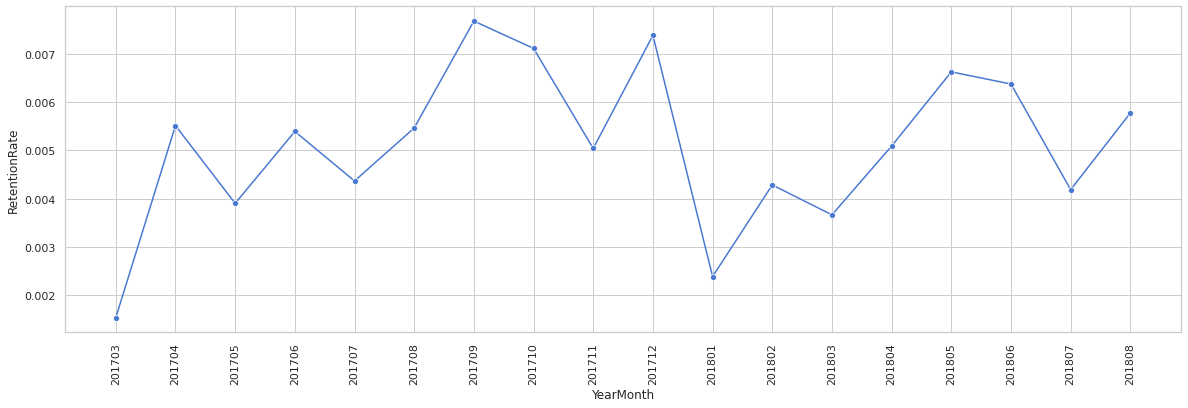

In [38]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
sns.lineplot(x=df_retention.YearMonth.astype(str), y=df_retention.RetentionRate, marker='o')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# Cohort Based Retention Rate

There is another way of measuring Retention Rate which allows you to see Retention Rate for each cohort. Cohorts are determined as first purchase year-month of the customers. We will be measuring what percentage of the customers retained after their first purchase in each month. This view will help us to see how recent and old cohorts differ regarding retention rate and if recent changes in customer experience affected new customer’s retention or not.

In [39]:
#create our retention table again with crosstab() - we need to change the column names for using them in .query() function

df_retention = pd.crosstab(df_user_purchase['CustomerUniqueID'], df_user_purchase['YearMonthInt']).reset_index()
new_column_names = [ 'm_' + str(column) for column in df_retention.columns]
df_retention.columns = new_column_names
df_retention.head()

,m_CustomerUniqueID,m_201701,m_201702,m_201703,m_201704,m_201705,m_201706,m_201707,m_201708,m_201709,m_201710,m_201711,m_201712,m_201801,m_201802,m_201803,m_201804,m_201805,m_201806,m_201807,m_201808
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0000f46a3911fa3c0805444483337064,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [40]:
#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = df_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(df_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)

In [41]:
#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = df_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(df_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
df_retention = pd.DataFrame(retention_array)
df_retention.index = months

#showing new cohort based retention table
df_retention

,TotalUserCount,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
YearMonthInt,,,,,,,,,,,,,,,,,,,,
201702,1708,1.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201703,2601,NaN,1.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201704,2359,NaN,NaN,1.0,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201705,3588,NaN,NaN,NaN,1.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201706,3154,NaN,NaN,NaN,NaN,1.0,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201707,3894,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201708,4211,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201709,4170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201710,4501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00


Note that the retention rate is basically zero. This is more visible from the count of orders from CustomerUniqueID

In [42]:
count = df["CustomerUniqueID"].value_counts().value_counts()
count

1     89527
2      4843
3       511
4       130
5        32
6        27
7        13
11        7
8         7
9         6
10        5
12        4
14        2
17        2
23        1
16        1
19        1
22        1
25        1
Name: CustomerUniqueID, dtype: int64

In [43]:
89527/95121

0.9411906939582216

94% of all customers on the platform have only made one transaction. Thus the retention rates are basically 0 almost everywhere.

In [44]:
# final dataframe before applying segmentation
df.head()

,OrderID,CustomerUniqueID,CustomerID,PurchaseTime,OrderStatus,PaymentValue,YearMonth,MinPurchaseDate,UserType,YearMonthInt
0,b81ef226f3fe1789b1e8b2acac839d17,708ab75d2a007f0564aedd11139c7708,0a8556ac6be836b46b3e89920d59291c,2018-04-25 22:01:49,delivered,99.33,2018-04,201804,New,201804
1,a9810da82917af2d9aefd1278f1dcfa0,a8b9d3a27068454b1c98cc67d4e31e6f,f2c7fc58a9de810828715166c672f10a,2018-06-26 11:01:38,delivered,24.39,2018-06,201806,New,201806
2,25e8ea4e93396b6fa0d3dd708e76c1bd,6f70c0b2f7552832ba46eb57b1c5651e,25b14b69de0b6e184ae6fe2755e478f9,2017-12-12 11:19:55,delivered,65.71,2017-12,201712,New,201712
3,ba78997921bbcdc1373bb41e913ab953,87695ed086ebd36f20404c82d20fca87,7a5d8efaaa1081f800628c30d2b0728f,2017-12-06 12:04:06,delivered,107.78,2017-12,201712,New,201712
4,42fdf880ba16b47b59251dd489d4441a,4291db0da71914754618cd789aebcd56,15fd6fb8f8312dbb4674e4518d6fa3b3,2018-05-21 13:59:17,delivered,128.45,2018-05,201805,New,201805


# 2 - Customer Segmentation

Customers who shop on Olist have different needs and they have their own different profile. We should adapt our actions depending on that.

RFM stands for Recency - Frequency - Monetary Value, I will be using this metrics to segment customers. Theoretically we will have segments like below:
Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

## Recency

To calculate recency, we need to find out most recent purchase date of each customer and see for how many days they are inactive. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [45]:
#creates a generic user dataframe to keep CustomerID and new segmentation scores
df_user = pd.DataFrame(df['CustomerUniqueID'])
df_user.columns = ['customer_unique_id']

#gets the max purchase date for each customer and create a dataframe with it
df_max_purchase = df.groupby('CustomerUniqueID').PurchaseTime.max().reset_index()
df_max_purchase.columns = ['customer_unique_id', 'MaxPurchaseDate']

#we take our observation point as the max purchase date in our dataset
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

df_user.head()

,customer_unique_id,Recency
0,708ab75d2a007f0564aedd11139c7708,125
1,a8b9d3a27068454b1c98cc67d4e31e6f,64
2,6f70c0b2f7552832ba46eb57b1c5651e,260
3,87695ed086ebd36f20404c82d20fca87,266
4,4291db0da71914754618cd789aebcd56,28


In [46]:
# getting summary statistics of the recency table
df_user.Recency.describe()

count    102131.000000
mean        237.107156
std         151.467282
min           0.000000
25%         114.000000
50%         218.000000
75%         347.000000
max         601.000000
Name: Recency, dtype: float64

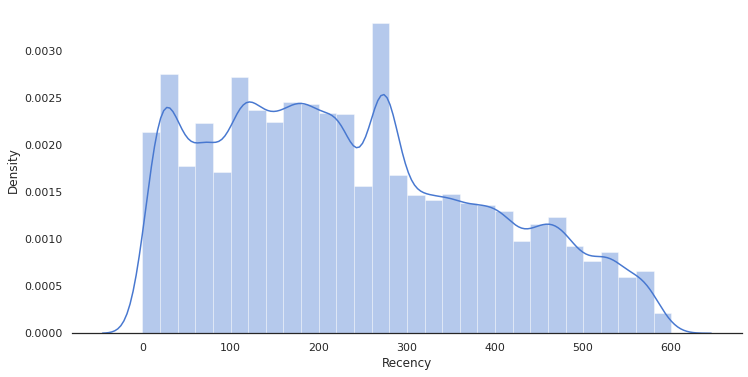

In [47]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Recency'], bins=30)
plt.show()

I will be applying K-means clustering to assign a recency score to each customer. But there is need to tell how many clusters i need to K-means algorithm. To find this out, I will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia.

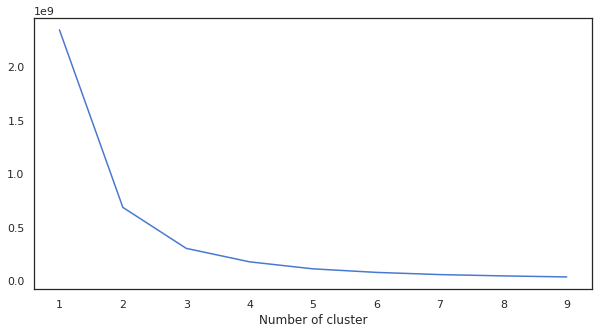

In [48]:
from sklearn.cluster import KMeans

sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Here it looks like 4 is the optimal number of clusters. Based on business requirements, I can go ahead with less or more clusters. In tis case i will be selecting 5.

In [49]:
#building 5 clusters for recency and adding it to dataframe
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [50]:
#displaying the details of each cluster
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,13367.0,502.955039,42.639343,439.0,466.0,496.0,537.0,601.0
1,16793.0,373.386351,34.616979,316.0,344.0,373.0,403.0,438.0
2,24706.0,256.494171,31.432753,203.0,228.0,261.0,278.0,315.0
3,26150.0,149.377859,30.365227,98.0,122.0,149.0,176.0,202.0
4,21115.0,46.390623,26.658250,0.0,23.0,42.0,70.0,97.0


From the above table the recency clusters have different characteristics. The customers in Cluster 4 are very recent compared to Cluster 3 and 2.
Hence cluster 4 covers the most active customers wheras cluster 0 covers the most inactive

## Frequency

To create frequency clusters, i will need to find total number orders for each customer, after which i cango ahead and place them in various clusters

In [51]:
#get order counts for each user and create a dataframe with it
df_frequency = df.groupby('CustomerUniqueID').PurchaseTime.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='customer_unique_id')

In [52]:
# getting summary statistics of the recency table
df_user.Frequency.describe()

count    102131.000000
mean          1.214803
std           1.027649
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          25.000000
Name: Frequency, dtype: float64

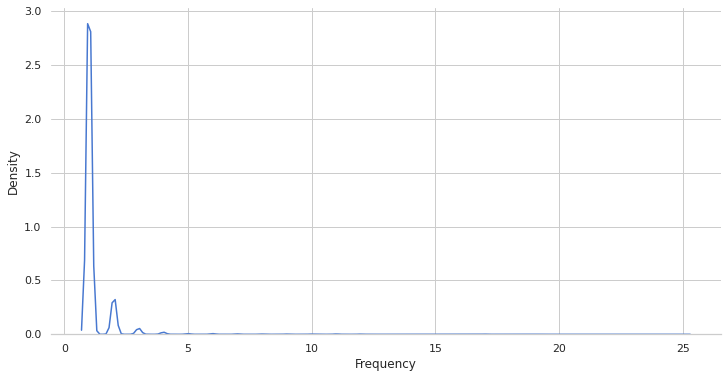

In [53]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Frequency'], hist=False)
plt.show()

In [54]:
#k-means
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

#order the frequency cluster
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

#see details of each cluster
df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,89527.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,11219.0,2.136643,0.343486,2.0,2.0,2.0,2.0,3.0
2,933.0,4.811361,1.042447,4.0,4.0,4.0,6.0,7.0
3,313.0,10.380192,1.744733,8.0,9.0,10.0,11.0,14.0
4,139.0,20.381295,3.275725,16.0,17.0,22.0,23.0,25.0


As the same notation as recency clusters, high frequency number indicates better customers.

## Revenue
Let’s see how our customer base looks like when I cluster them based on revenue. I will calculate revenue for each customer, plot a histogram and apply the same clustering method.

In [55]:
#calculate revenue for each customer
df_revenue = df.groupby('CustomerUniqueID').PaymentValue.sum().reset_index()
df_revenue.columns = ['customer_unique_id','payment_value']

#merge it with our main dataframe
df_user = pd.merge(df_user, df_revenue, on='customer_unique_id')

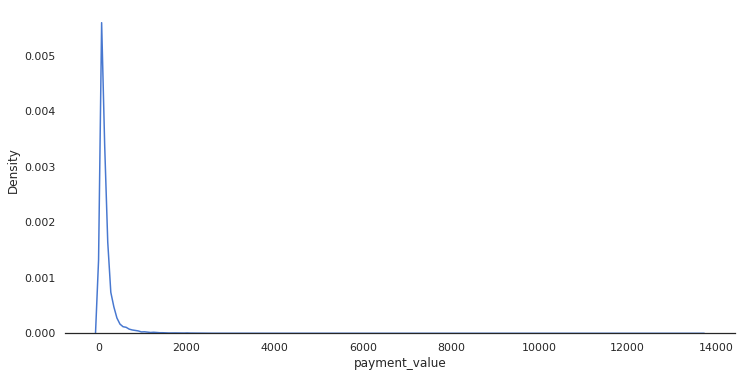

In [56]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['payment_value'], hist=False)
plt.show()

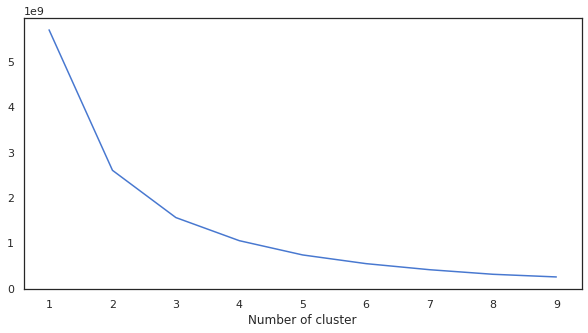

In [57]:
sse={}
df_revenue = df_user[['payment_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [58]:
#apply clustering
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_user[['payment_value']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['payment_value']])


#order the cluster numbers
df_user = order_cluster('RevenueCluster', 'payment_value',df_user,True)

#show details of the dataframe
df_user.groupby('RevenueCluster')['payment_value'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,64851.0,77.971738,33.918851,6.18,49.380,73.860,105.3000,146.02
1,27829.0,213.426664,53.797013,146.03,168.290,199.070,247.5000,349.19
2,6928.0,483.287955,109.456812,349.28,388.660,451.735,562.2425,745.51
3,2015.0,1006.050983,206.843702,745.69,829.365,942.780,1149.3550,1511.86
4,472.0,2025.935763,429.580655,1517.70,1693.130,1926.595,2202.8100,3406.47
5,36.0,4966.484167,1926.855327,3526.46,4007.570,4194.760,4775.6150,13664.08


## Overall Score

After creating various metric scores (cluster numbers) for recency, frequency & revenue. now i will proceed to create an overall score out of them:

In [59]:
# #renaming columns
# df_user.columns = ['customer_unique_id','Frequency', 'FrequencyCluster', 'Monetary', 'RevenueCluster']
# #calculate overall score and use mean() to see details
# df_user['OverallScore'] = df_user['FrequencyCluster'] + df_user['RevenueCluster']
# df_user.groupby('OverallScore')['Frequency','Monetary'].mean()

The scoring above clearly shows us that customers with score 12 is our best customers whereas 0 is the worst.

To keep things simple, better we name these scores:
- 0 to 4: Low Value
- 5 to 7: Mid Value
- 8+: High Value

In [60]:
# df_user['Segment'] = 'Low-Value'
# df_user.loc[df_user['OverallScore']>3,'Segment'] = 'Mid-Value' 
# df_user.loc[df_user['OverallScore']>6,'Segment'] = 'High-Value' 

In [61]:
# df_user.head()

In [62]:
# # plotting the distribution of the continous feature set
# sns.set(palette='muted', color_codes=True, style='whitegrid')
# fig, axs = plt.subplots(1, 3, figsize=(22, 5))
# sns.despine(left=True)
# sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Segment', data=df_user, size='Segment', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
# sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
# sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
# axs[0].set_title('Customer Segments by Recency & Frequency')
# axs[1].set_title('Customer Segments by Frequency & Monetary')
# axs[2].set_title('Customer Segments by Recency & Monetary')
# plt.show()

# 3 - Customer Lifetime Value

### 4months RFM scoring and Clustering 
- We took 4 months and 6 months of the data.
- 4 months of data to calculate RFM scores, and to use it to predict 6 months of data.

In [63]:
# Preparing to separate df into 4 and 6 months
clv_df = df[['CustomerUniqueID','PurchaseTime','PaymentValue']]
clv_df['PurchaseTime'] = pd.to_datetime(clv_df['PurchaseTime']).dt.date
clv_df.columns = ['customer_unique_id','PurchaseTime','Revenue']
clv_df

,customer_unique_id,PurchaseTime,Revenue
0,708ab75d2a007f0564aedd11139c7708,2018-04-25,99.33
1,a8b9d3a27068454b1c98cc67d4e31e6f,2018-06-26,24.39
2,6f70c0b2f7552832ba46eb57b1c5651e,2017-12-12,65.71
3,87695ed086ebd36f20404c82d20fca87,2017-12-06,107.78
4,4291db0da71914754618cd789aebcd56,2018-05-21,128.45
...,...,...,...
102126,13f283df2f4760f22b57830865761d07,2018-05-16,198.94
102127,b6027ac07fb76ebca8c97b1887865aee,2018-03-08,363.31
102128,d3c7da954a324253814096bcaf240e4e,2017-11-18,47.77
102129,b84dc68f02f122a88d7e7bbd37b06204,2018-08-07,369.54


In [64]:
clv_df['customer_unique_id'].value_counts()

8af7ac63b2efbcbd88e5b11505e8098a    25
f9ae226291893fda10af7965268fb7f6    23
569aa12b73b5f7edeaa6f2a01603e381    22
2524dcec233c3766f2c2b22f69fd65f4    19
24f12460aad399ba18f4ed2c2fbab65d    17
                                    ..
3c569102e3f62b32eb0300a277e57385     1
042c4b7a631b4e91da36716f93e7e017     1
50602f98fb19ae4764267722678e0b12     1
4255da282ea330efb8c5bc902bda9c83     1
b1f51a4e19da3338e51fbcfabefad1bf     1
Name: customer_unique_id, Length: 95121, dtype: int64

In [65]:
# Time range of customer purchase
maxdate = clv_df['PurchaseTime'].max()
mindate = clv_df['PurchaseTime'].min()
print(f"Time range of the transactions are : {mindate} to {maxdate}")

Time range of the transactions are : 2017-01-05 to 2018-08-29


In [66]:
# Create 4 month and 6 month dataframes
df_4m = clv_df[(clv_df.PurchaseTime < date(2018,3,1)) & (clv_df.PurchaseTime >= date(2017,11,1))].reset_index(drop=True)
df_6m = clv_df[(clv_df.PurchaseTime >= date(2018,3,1)) & (clv_df.PurchaseTime < date(2018,9,1))].reset_index(drop=True)

In [67]:
# Check and dropping duplicates
df_4m = df_4m.drop_duplicates(keep='first')
df_4m.duplicated().any()

False

In [68]:
df_4m['customer_unique_id'].value_counts()

2524dcec233c3766f2c2b22f69fd65f4    19
85963fd37bfd387aa6d915d8a1065486    12
3806104dbbc3d14c17b091b3b8e38d59    10
e0ff4805ba6693550d1db7d374c477c9     9
90807fdb59eec2152bc977feeb6e47e7     8
                                    ..
883ce6de316525ee6c45bdc335c0494f     1
b76fa65d01d7c65222cae9a5a97595fd     1
cd43869bea949bd24f06977485cef68b     1
19c594ece92cf53919f2a6491dc3b8ea     1
b1f51a4e19da3338e51fbcfabefad1bf     1
Name: customer_unique_id, Length: 26411, dtype: int64

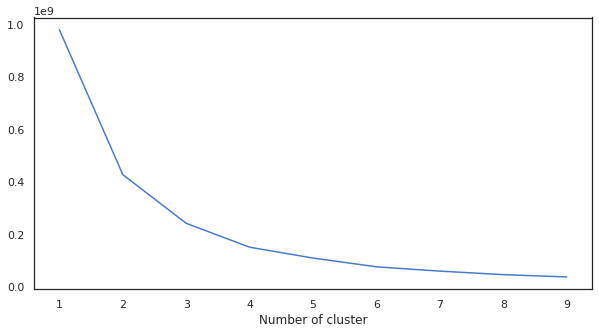

In [69]:
# Calculating revenue for 4 months data 
df_user_4m = df_4m.groupby('customer_unique_id')['Revenue'].sum().reset_index()


# Check number of clusters
sse={}
df_revenue02 = df_user_4m[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue02)
    df_revenue02["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [70]:
# Creating 3 clusters
km = KMeans(n_clusters=3)
km.fit(df_user_4m[['Revenue']])
df_user_4m['RevenueCluster_4m'] = km.predict(df_user_4m[['Revenue']])

# Ordering cluster method
df_user_4m = order_cluster('RevenueCluster_4m', 'Revenue',df_user_4m,True)

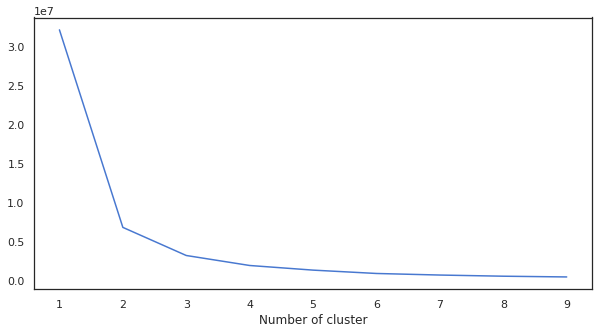

In [71]:
# Calculating recency score for 4 months data
max_purchase = df_4m.groupby('customer_unique_id').PurchaseTime.max().reset_index()
max_purchase.columns = ['customer_unique_id','MaxPurchaseDate']
max_purchase['Recency_4m'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days
df_user_4m = pd.merge(df_user_4m, max_purchase[['customer_unique_id','Recency_4m']], on='customer_unique_id')


# Check number of clusters using Elbow Method to get the optimal cluster number for optimal inertia
sse={}
df_recency02 = df_user_4m[['Recency_4m']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency02)
    df_recency02["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [72]:
# Creating 3 clusters
km = KMeans(n_clusters=3)
km.fit(df_user_4m[['Recency_4m']])
df_user_4m['RecencyCluster_4m'] = km.predict(df_user_4m[['Recency_4m']])

# Ordering cluster method
df_user_4m = order_cluster('RecencyCluster_4m', 'Recency_4m',df_user_4m,False)
df_user_4m.head()

,customer_unique_id,Revenue,RevenueCluster_4m,Recency_4m,RecencyCluster_4m
0,0004aac84e0df4da2b147fca70cf8255,196.89,0,106,0
1,00082cbe03e478190aadbea78542e933,126.26,0,101,0
2,000c8bdb58a29e7115cfc257230fb21b,29.00,0,78,0
3,001ae44fa04911a9e9577356dce6c63c,116.23,0,114,0
4,001ae5a1788703d64536c30362503e49,135.08,0,82,0


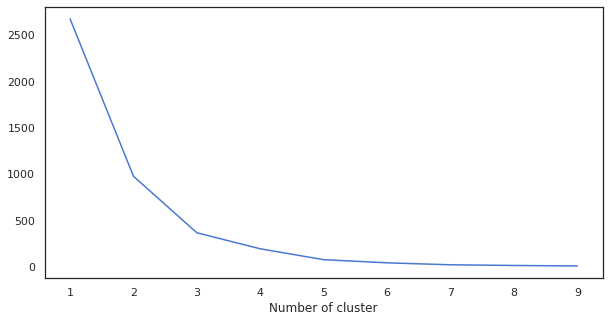

In [73]:
# Calcuate frequency score for 4 months data
df_frequency02 = df_4m.groupby('customer_unique_id').PurchaseTime.count().reset_index()
df_frequency02.columns = ['customer_unique_id','Frequency_4m']
df_user_4m = pd.merge(df_user_4m, df_frequency02, on='customer_unique_id')


# Check number of clusters
sse={}
df_frequency02 = df_user_4m[['Frequency_4m']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_frequency02)
    df_frequency02["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [74]:
# Creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_user_4m[['Frequency_4m']])
df_user_4m['FrequencyCluster_4m'] = kmeans.predict(df_user_4m[['Frequency_4m']])

# Ordering cluster method
df_user_4m = order_cluster('FrequencyCluster_4m', 'Frequency_4m',df_user_4m,True)
df_user_4m

,customer_unique_id,Revenue,RevenueCluster_4m,Recency_4m,RecencyCluster_4m,Frequency_4m,FrequencyCluster_4m
0,0004aac84e0df4da2b147fca70cf8255,196.89,0,106,0,1,0
1,00082cbe03e478190aadbea78542e933,126.26,0,101,0,1,0
2,000c8bdb58a29e7115cfc257230fb21b,29.00,0,78,0,1,0
3,001ae44fa04911a9e9577356dce6c63c,116.23,0,114,0,1,0
4,001ae5a1788703d64536c30362503e49,135.08,0,82,0,1,0
...,...,...,...,...,...,...,...
26406,31628ac4d85d1c46ebf7dad444adcbe3,163.81,0,4,2,7,2
26407,7b08fc11e1aacd85ef2845c12a9ddb81,273.67,0,1,2,6,2
26408,85963fd37bfd387aa6d915d8a1065486,879.44,1,14,2,12,2
26409,1b6c7548a2a1f9037c1fd3ddfed95f33,959.01,2,14,2,8,2


In [75]:
# Dropping recency
# df_user_4m = df_user_4m.drop(['Recency_4m','RecencyCluster_4m'], axis=1)
df_user_4m

,customer_unique_id,Revenue,RevenueCluster_4m,Recency_4m,RecencyCluster_4m,Frequency_4m,FrequencyCluster_4m
0,0004aac84e0df4da2b147fca70cf8255,196.89,0,106,0,1,0
1,00082cbe03e478190aadbea78542e933,126.26,0,101,0,1,0
2,000c8bdb58a29e7115cfc257230fb21b,29.00,0,78,0,1,0
3,001ae44fa04911a9e9577356dce6c63c,116.23,0,114,0,1,0
4,001ae5a1788703d64536c30362503e49,135.08,0,82,0,1,0
...,...,...,...,...,...,...,...
26406,31628ac4d85d1c46ebf7dad444adcbe3,163.81,0,4,2,7,2
26407,7b08fc11e1aacd85ef2845c12a9ddb81,273.67,0,1,2,6,2
26408,85963fd37bfd387aa6d915d8a1065486,879.44,1,14,2,12,2
26409,1b6c7548a2a1f9037c1fd3ddfed95f33,959.01,2,14,2,8,2


In [76]:
# Calculate overall score and use mean() to see details
df_user_4m['OverallScore'] = df_user_4m['RecencyCluster_4m'] + df_user_4m['FrequencyCluster_4m'] + df_user_4m['RevenueCluster_4m']
df_user_4m.groupby('OverallScore')['Recency_4m','Frequency_4m','Revenue'].mean()

,Recency_4m,Frequency_4m,Revenue
OverallScore,,,
0,93.973045,1.000000,107.276000
1,57.532974,1.050410,154.575381
2,21.618737,1.065032,162.262816
3,19.852814,1.374026,438.048113
4,16.069444,1.833333,834.929792
5,10.100000,3.000000,1242.382000
6,7.500000,8.000000,1016.475000


In [77]:
# Check each cluster count to determine the segment
df_user_4m.groupby('OverallScore')['Revenue'].count()

OverallScore
0    9423
1    8173
2    7504
3    1155
4     144
5      10
6       2
Name: Revenue, dtype: int64

Converting into categorical values:
- 0-2: Low Value
- 3-4: Mid Value
- 5-6: High Value

In [78]:
# Overall scoring
df_user_4m['Segment'] = 'Low-Value'
df_user_4m.loc[df_user_4m['OverallScore'] > 2,'Segment'] = 'Mid-Value' 
df_user_4m.loc[df_user_4m['OverallScore'] > 4,'Segment'] = 'High-Value' 

### Correlations between CLV and 6m cluster

In [79]:
# 6 months LTV for each customer which we are going to use for training our model
df_6m = df_6m.drop_duplicates(keep='first')
df_6m['customer_unique_id'].value_counts()

1bc3d5e384c365c86cf79078f32eb495    12
25ba76039a1caff121dfcb0d66e54780    12
024676cef113f6c81db6c5b8d29e5ee9    11
0fff4016f4008007ba2bb7d63ebae39d     9
8d50f5eadf50201ccdcedfb9e2ac8455     7
                                    ..
6d39d766befec9086938442ac22ecc16     1
ca6a08cf73e5804caebd8c0544941afb     1
6a296ad35a38d489b7ffc694291e5ed0     1
abe24bdb42358f26fb23b65fde785cfd     1
b84dc68f02f122a88d7e7bbd37b06204     1
Name: customer_unique_id, Length: 39163, dtype: int64

In [80]:
# Calculating Revenue for 6 months data
# Using Revenue as direct CLV 
df_user_6m = df_6m.groupby('customer_unique_id')['Revenue'].sum().reset_index()
df_user_6m

,customer_unique_id,Revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0004bd2a26a76fe21f786e4fbd80607f,166.98
3,00050ab1314c0e55a6ca13cf7181fecf,35.38
4,0005ef4cd20d2893f0d9fbd94d3c0d97,129.76
...,...,...
39158,fff3e1d7bc75f11dc7670619b2e61840,82.51
39159,fff5eb4918b2bf4b2da476788d42051c,2844.96
39160,fff96bc586f78b1f070da28c4977e810,63.42
39161,fffcc512b7dfecaffd80f13614af1d16,710.70


We will merge our 4 months and 6 months dataframes to see correlations between CLV and the feature set we have.

In [81]:
# Creating new df with 4 months and 6 months df
df_merge02 = pd.merge(df_user_4m, df_user_6m, on='customer_unique_id', how='left', suffixes=['_4m', '_6m'])

# treating nan values with replacing into 0
df_merge02 = df_merge02.fillna(0)

# Mean for each segment
df_merge02.groupby('Segment')['Revenue_6m'].mean()


Segment
High-Value    76.588333
Low-Value      2.110896
Mid-Value      3.795758
Name: Revenue_6m, dtype: float64

In [82]:
# Count customer who made a purchase in both 4 and 6 months period
df_merge02['Revenue_6m'].value_counts()

0.00      26046
87.18         2
95.40         2
199.14        2
40.25         2
          ...  
98.26         1
50.13         1
228.87        1
138.65        1
630.12        1
Name: Revenue_6m, Length: 358, dtype: int64

In [83]:
df_merge02.duplicated().sum()

0

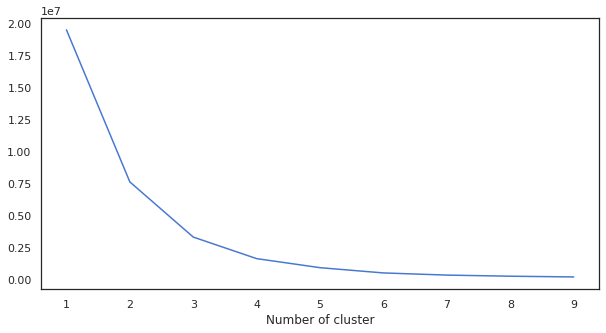

In [84]:
# Check number of clusters
sse={}
df_revenue_6m = df_merge02[['Revenue_6m']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue_6m)
    df_revenue_6m["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [85]:
#creating 2 clusters
km = KMeans(n_clusters=2)
km.fit(df_merge02[['Revenue_6m']])
df_merge02['CLVCluster'] = km.predict(df_merge02[['Revenue_6m']])


# Ordering cluster number based on CLV
df_merge02 = order_cluster('CLVCluster', 'Revenue_6m', df_merge02, True)

# Check details of the clusters
df_merge02.groupby('CLVCluster')['Revenue_6m'].describe()

,count,mean,std,min,25%,50%,75%,max
CLVCluster,,,,,,,,
0,26260.0,0.618789,7.428333,0.00,0.00,0.00,0.00,139.96
1,151.0,282.012185,202.833910,143.04,169.12,202.94,294.62,1402.32


With Outlier: 

Cluster 1 is the best with average 282, whereas Cluster 0 is the worst with 0.6.

In [86]:
# Making a copy of the df - with outlier
df_cluster = df_merge02.copy()
df_cluster.head()

,customer_unique_id,Revenue_4m,RevenueCluster_4m,Recency_4m,RecencyCluster_4m,Frequency_4m,FrequencyCluster_4m,OverallScore,Segment,Revenue_6m,CLVCluster
0,0004aac84e0df4da2b147fca70cf8255,196.89,0,106,0,1,0,0,Low-Value,0.0,0
1,00082cbe03e478190aadbea78542e933,126.26,0,101,0,1,0,0,Low-Value,0.0,0
2,000c8bdb58a29e7115cfc257230fb21b,29.00,0,78,0,1,0,0,Low-Value,0.0,0
3,001ae44fa04911a9e9577356dce6c63c,116.23,0,114,0,1,0,0,Low-Value,0.0,0
4,001ae5a1788703d64536c30362503e49,135.08,0,82,0,1,0,0,Low-Value,0.0,0


### Feature Engineering

In [87]:
# Drop customerID column
df_cluster = df_cluster.iloc[:, 1:]

# Convert categorical variable into dummy/indicator variables
df_cluster = pd.get_dummies(df_cluster)

In [88]:
# Correlation matrix
corr_matrix = df_cluster.corr()
corr_matrix['CLVCluster'].sort_values(ascending=False)

CLVCluster             1.000000
Revenue_6m             0.780633
Segment_High-Value     0.045513
OverallScore           0.031738
RecencyCluster_4m      0.025703
FrequencyCluster_4m    0.025237
Frequency_4m           0.019748
Revenue_4m             0.013858
Segment_Mid-Value      0.012942
RevenueCluster_4m      0.008116
Segment_Low-Value     -0.017352
Recency_4m            -0.026545
Name: CLVCluster, dtype: float64

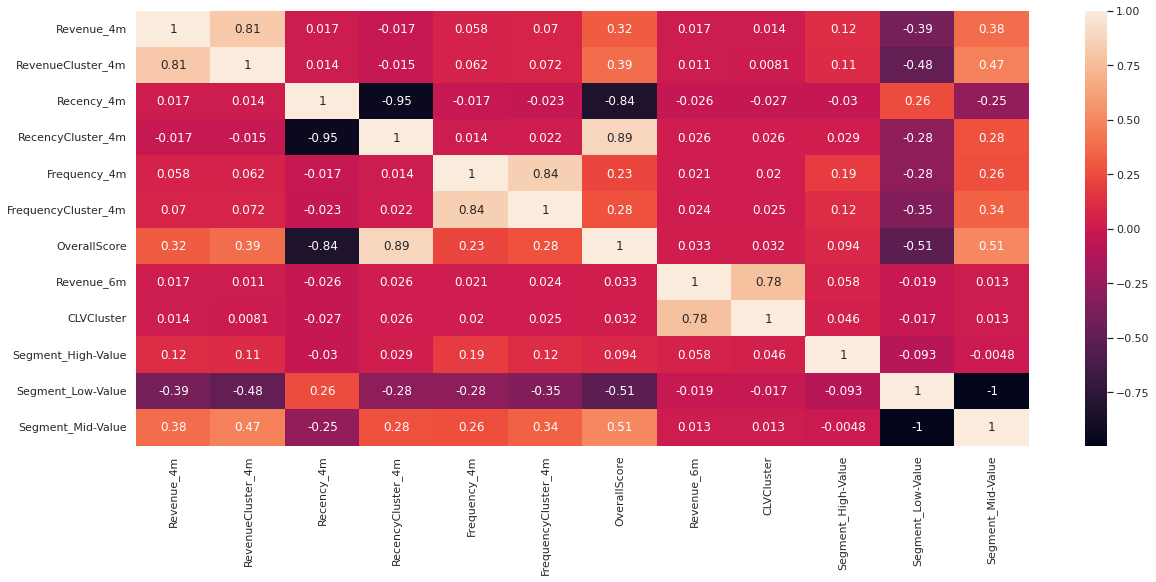

In [89]:
sns.heatmap(corr_matrix, annot=True)

In [90]:
# Feature scaling using Robust Scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_cluster))
scaled_df.columns = df_cluster.columns
scaled_df

# # Feature scaling using Standard Scaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled_df = pd.DataFrame(scaler.fit_transform(df_cluster))
# scaled_df.columns = df_cluster.columns
# scaled_df
# # Gives an error: Unknown label type: 'continuous'

,Revenue_4m,RevenueCluster_4m,Recency_4m,RecencyCluster_4m,Frequency_4m,FrequencyCluster_4m,OverallScore,Revenue_6m,CLVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,0.785792,0.0,0.781250,-0.5,0.0,0.0,-0.5,0.00,0.0,0.0,0.0,0.0
1,0.173879,0.0,0.703125,-0.5,0.0,0.0,-0.5,0.00,0.0,0.0,0.0,0.0
2,-0.668746,0.0,0.343750,-0.5,0.0,0.0,-0.5,0.00,0.0,0.0,0.0,0.0
3,0.086983,0.0,0.906250,-0.5,0.0,0.0,-0.5,0.00,0.0,0.0,0.0,0.0
4,0.250292,0.0,0.406250,-0.5,0.0,0.0,-0.5,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26406,2.993979,1.0,-0.703125,0.5,2.0,1.0,1.5,381.88,1.0,0.0,-1.0,1.0
26407,2.346112,1.0,-0.875000,0.5,1.0,1.0,1.5,202.79,1.0,0.0,-1.0,1.0
26408,2.488282,1.0,-0.531250,0.5,1.0,1.0,1.5,243.40,1.0,0.0,-1.0,1.0
26409,7.441022,2.0,-0.781250,0.5,1.0,1.0,2.0,288.94,1.0,1.0,-1.0,0.0


In [91]:
# Create x (feature set), y (target set) - with outlier
x = scaled_df.drop(['CLVCluster','Revenue_6m'],axis=1)
y = scaled_df['CLVCluster']


# Split training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

### Random Over sampling

In [92]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

In [93]:
# #printing the #obs of each class before oversampling
# print('Before : ',Counter(y_train), '\n')

# #applying SMOTE
# smt = SMOTE( sampling_strategy={0:21006,1:21006}, k_neighbors=2, random_state=1)
# x_train_over, y_train_over = smt.fit_resample(x_train, y_train)

# over = RandomOverSampler()
# x_test_over, y_test_over = over.fit_resample(x_test, y_test)

# #printing the #obs of each class after oversampling
# print('After : ',Counter(y_train_over))
# print('After : ',Counter(y_test_over))

In [94]:
#sns.scatterplot(x_over[:,0], x_over[:,1], x_over[:,2], hue=y_over, alpha=.5)

In [95]:
print('Train Before : ',Counter(y_train))
print('Test Before : ',Counter(y_test),'\n')

# Initiating random undersampler
under = RandomUnderSampler()
# Resampling x, y
x_train_under, y_train_under = under.fit_resample(x_train, y_train)
x_test_under, y_test_under = under.fit_resample(x_test, y_test)

print('Train After : ',Counter(y_train_under))
print('Test After : ',Counter(y_test_under))

Train Before :  Counter({0.0: 19690, 1.0: 118})
Test Before :  Counter({0.0: 6570, 1.0: 33}) 

Train After :  Counter({0.0: 118, 1.0: 118})
Test After :  Counter({0.0: 33, 1.0: 33})


In [96]:
y_train_under.shape

(236,)

### Model Building

In [97]:
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

In [98]:
# # Creating object of the models
xg = XGBClassifier(random_state=1, use_label_encoder=False)
bc = BaggingClassifier() 
ada = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
rf = RandomForestClassifier(n_estimators= 5, criterion="entropy")
dt = DecisionTreeClassifier()
lg = LogisticRegression()
svc = SVC()
nb = GaussianNB()

In [99]:
# List of models
#models_2 = [rf, dt]
models_2 = [xg, bc, ada, gbc, rf, dt, lg, svc]
models_2

[XGBClassifier(random_state=1, use_label_encoder=False),
 BaggingClassifier(),
 AdaBoostClassifier(),
 GradientBoostingClassifier(),
 RandomForestClassifier(criterion='entropy', n_estimators=5),
 DecisionTreeClassifier(),
 LogisticRegression(),
 SVC()]

In [100]:
## Classification Report - undersample
for i in models_2:

  # Model fit to train data
  i.fit(x_train_under, y_train_under)
  
  # Predicting on test
  pred_test2 = i.predict(x_test_under)
  acc_test2 = accuracy_score(y_test_under, pred_test2)

  # Predicting on train
  pred_train2 = i.predict(x_train_under)
  acc_train2 = accuracy_score(y_train_under, pred_train2)

  ##classification report
  report_under = classification_report(y_test_under, pred_test2)
  print(f"{i} Classification report on under sampled data\n\n",report_under)


  print(f"Test accuracy for {i} is: {acc_test2}")
  print(f"Train accuracy for {i} is: {acc_train2}\n\n")

XGBClassifier(random_state=1, use_label_encoder=False) Classification report on under sampled data

               precision    recall  f1-score   support

         0.0       0.55      0.48      0.52        33
         1.0       0.54      0.61      0.57        33

    accuracy                           0.55        66
   macro avg       0.55      0.55      0.54        66
weighted avg       0.55      0.55      0.54        66

Test accuracy for XGBClassifier(random_state=1, use_label_encoder=False) is: 0.5454545454545454
Train accuracy for XGBClassifier(random_state=1, use_label_encoder=False) is: 0.8135593220338984


BaggingClassifier() Classification report on under sampled data

               precision    recall  f1-score   support

         0.0       0.56      0.58      0.57        33
         1.0       0.56      0.55      0.55        33

    accuracy                           0.56        66
   macro avg       0.56      0.56      0.56        66
weighted avg       0.56      0.56      